# Final Out-of-Sample Evaluation (2024-2026 Holdout)

## ⚠️ THIS IS THE FINAL TEST - NO PEEKING ALLOWED AFTER THIS

Following **fob.instructions**: We have kept the 2024-2026 holdout period completely untouched
throughout all research. This notebook evaluates our final strategy on this unseen data.

### Strategy Configuration (From Notebook 02)
- **Signal**: 60% Momentum (126d-42d) + 40% Mean Reversion (21d)
- **Rebalancing**: Monthly (every 21 trading days)
- **Transaction Costs**: 10 bps per trade

### In-Sample Metrics (2016-2023)
- Gross Sharpe: +0.50
- Net Sharpe: +0.42
- Net Return: +3.28%/year
- Max Drawdown: -11.3%
- Turnover: 6.2x/year

---

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

DATA_DIR = Path('c:/Users/ponna/OneDrive/Desktop/Precog Task/data/raw/assets')
OUTPUT_DIR = Path('c:/Users/ponna/OneDrive/Desktop/Precog Task/research/outputs')

print("✅ Environment ready for final evaluation")

✅ Environment ready for final evaluation


In [2]:
# Load all data
asset_files = sorted(DATA_DIR.glob('Asset_*.csv'))
print(f"Loading {len(asset_files)} assets...")

prices_list = []
for f in asset_files:
    ticker = f.stem
    df = pd.read_csv(f, parse_dates=['Date'], index_col='Date')
    df = df[['Close']].rename(columns={'Close': ticker})
    prices_list.append(df)

prices = pd.concat(prices_list, axis=1).sort_index().ffill().bfill()
returns = prices.pct_change().dropna()

print(f"Date Range: {returns.index[0]} to {returns.index[-1]}")
print(f"Total Days: {len(returns)}")

Loading 100 assets...
Date Range: 2016-01-26 00:00:00 to 2026-01-16 00:00:00
Total Days: 2510


In [3]:
# Split into In-Sample and Holdout
HOLDOUT_START = '2024-01-01'

returns_is = returns[returns.index < HOLDOUT_START]
returns_oos = returns[returns.index >= HOLDOUT_START]

print(f"In-Sample Period: {returns_is.index[0].date()} to {returns_is.index[-1].date()}")
print(f"  Days: {len(returns_is)}")
print(f"\nHoldout Period: {returns_oos.index[0].date()} to {returns_oos.index[-1].date()}")
print(f"  Days: {len(returns_oos)}")
print(f"\n⚠️ This is the FIRST TIME we look at holdout data!")

In-Sample Period: 2016-01-26 to 2023-12-29
  Days: 1997

Holdout Period: 2024-01-02 to 2026-01-16
  Days: 513

⚠️ This is the FIRST TIME we look at holdout data!


In [4]:
# Define signal computation functions (same as Notebook 02)

def compute_simple_momentum(returns, lookback=126, skip=42):
    """12-1 style momentum: past return excluding recent month."""
    total_ret = (1 + returns).rolling(lookback + skip).apply(lambda x: x[:lookback].prod(), raw=False) - 1
    return total_ret

def compute_mean_reversion(returns, window=21):
    """Short-term mean reversion signal."""
    recent_ret = returns.rolling(window).sum()
    return -recent_ret  # Negative because we want to buy losers

def apply_rebalance_frequency(alpha, freq_days=21):
    """Only update positions every freq_days."""
    result = alpha.copy()
    last_rebal = None
    
    for i, date in enumerate(alpha.index):
        if last_rebal is None or i % freq_days == 0:
            last_rebal = alpha.iloc[i]
        else:
            result.iloc[i] = last_rebal
    
    return result

def compute_portfolio_weights(alpha):
    """Convert alpha to dollar-neutral long/short weights."""
    # Rank-based weights
    ranks = alpha.rank(axis=1, pct=True)
    
    # Dollar neutral: long top 50%, short bottom 50%
    weights = ranks - 0.5
    
    # Normalize to sum to 0 (dollar neutral) with total exposure = 1
    abs_sum = weights.abs().sum(axis=1)
    weights = weights.div(abs_sum, axis=0)
    
    return weights

def backtest_strategy(returns, lookback=126, skip=42, rev_window=21, 
                      mom_weight=0.6, rev_weight=0.4, rebal_freq=21, tc_bps=10):
    """
    Full backtest of momentum + reversion strategy.
    Returns metrics dictionary.
    """
    # Compute signals
    mom = compute_simple_momentum(returns, lookback=lookback, skip=skip)
    rev = compute_mean_reversion(returns, window=rev_window)
    
    # Normalize signals
    mom_norm = mom.rank(axis=1, pct=True) - 0.5
    rev_norm = rev.rank(axis=1, pct=True) - 0.5
    
    # Combine
    alpha = mom_weight * mom_norm + rev_weight * rev_norm
    
    # Apply rebalancing frequency
    alpha = apply_rebalance_frequency(alpha, freq_days=rebal_freq)
    
    # Get weights
    weights = compute_portfolio_weights(alpha)
    
    # Portfolio returns (with lag for realistic execution)
    pf_returns = (weights.shift(1) * returns).sum(axis=1)
    
    # Turnover
    turnover = weights.diff().abs().sum(axis=1)
    
    # Transaction costs
    tc = turnover * (tc_bps / 10000)
    pf_returns_net = pf_returns - tc
    
    # Metrics
    ann_factor = 252
    
    gross_ret = pf_returns.mean() * ann_factor
    gross_vol = pf_returns.std() * np.sqrt(ann_factor)
    gross_sharpe = gross_ret / gross_vol if gross_vol > 0 else 0
    
    net_ret = pf_returns_net.mean() * ann_factor
    net_vol = pf_returns_net.std() * np.sqrt(ann_factor)
    net_sharpe = net_ret / net_vol if net_vol > 0 else 0
    
    cum_pnl_gross = (1 + pf_returns.fillna(0)).cumprod()
    cum_pnl_net = (1 + pf_returns_net.fillna(0)).cumprod()
    
    max_dd_gross = (cum_pnl_gross / cum_pnl_gross.cummax() - 1).min()
    max_dd_net = (cum_pnl_net / cum_pnl_net.cummax() - 1).min()
    
    ann_turnover = turnover.mean() * ann_factor
    
    return {
        'gross_sharpe': gross_sharpe,
        'net_sharpe': net_sharpe,
        'gross_return': gross_ret,
        'net_return': net_ret,
        'gross_vol': gross_vol,
        'net_vol': net_vol,
        'max_dd_gross': max_dd_gross,
        'max_dd_net': max_dd_net,
        'ann_turnover': ann_turnover,
        'cumulative_gross': cum_pnl_gross,
        'cumulative_net': cum_pnl_net,
        'daily_returns_net': pf_returns_net,
        'weights': weights
    }

print("✅ Strategy functions defined")

✅ Strategy functions defined


## In-Sample Verification

First, verify that our strategy matches the in-sample results from Notebook 02.

In [5]:
# Run on In-Sample data to verify
is_results = backtest_strategy(
    returns_is,
    lookback=126,
    skip=42,
    rev_window=21,
    mom_weight=0.6,
    rev_weight=0.4,
    rebal_freq=21,
    tc_bps=10
)

print("IN-SAMPLE VERIFICATION (2016-2023):")
print("="*50)
print(f"Gross Sharpe:   {is_results['gross_sharpe']:.4f} (expected ~0.50)")
print(f"Net Sharpe:     {is_results['net_sharpe']:.4f} (expected ~0.42)")
print(f"Net Return:     {is_results['net_return']*100:.2f}% (expected ~3.28%)")
print(f"Max Drawdown:   {is_results['max_dd_net']*100:.2f}% (expected ~-11.3%)")
print(f"Turnover:       {is_results['ann_turnover']:.1f}x (expected ~6.2x)")

IN-SAMPLE VERIFICATION (2016-2023):
Gross Sharpe:   0.3298 (expected ~0.50)
Net Sharpe:     0.1751 (expected ~0.42)
Net Return:     1.07% (expected ~3.28%)
Max Drawdown:   -11.80% (expected ~-11.3%)
Turnover:       9.5x (expected ~6.2x)


## 🎯 OUT-OF-SAMPLE EVALUATION (HOLDOUT)

This is the moment of truth. We evaluate on 2024-2026 data that was never seen during research.

In [6]:
# OUT-OF-SAMPLE TEST
print("="*60)
print("🎯 OUT-OF-SAMPLE EVALUATION (2024-2026 HOLDOUT)")
print("="*60)
print("\n⚠️ EVALUATING ON UNSEEN DATA...\n")

# Run strategy on holdout period
oos_results = backtest_strategy(
    returns_oos,
    lookback=126,
    skip=42,
    rev_window=21,
    mom_weight=0.6,
    rev_weight=0.4,
    rebal_freq=21,
    tc_bps=10
)

print(f"OUT-OF-SAMPLE RESULTS:")
print(f"─"*40)
print(f"Gross Sharpe:    {oos_results['gross_sharpe']:.4f}")
print(f"Net Sharpe:      {oos_results['net_sharpe']:.4f}")
print(f"Gross Return:    {oos_results['gross_return']*100:.2f}%")
print(f"Net Return:      {oos_results['net_return']*100:.2f}%")
print(f"Volatility:      {oos_results['net_vol']*100:.2f}%")
print(f"Max Drawdown:    {oos_results['max_dd_net']*100:.2f}%")
print(f"Turnover:        {oos_results['ann_turnover']:.1f}x")

# Compare to in-sample
print(f"\nIN-SAMPLE vs OUT-OF-SAMPLE COMPARISON:")
print(f"─"*40)
print(f"{'Metric':<20} {'In-Sample':>12} {'Out-Sample':>12} {'Change':>10}")
print(f"{'─'*54}")
print(f"{'Net Sharpe':<20} {is_results['net_sharpe']:>12.3f} {oos_results['net_sharpe']:>12.3f} {oos_results['net_sharpe']-is_results['net_sharpe']:>+10.3f}")
print(f"{'Net Return':<20} {is_results['net_return']*100:>11.2f}% {oos_results['net_return']*100:>11.2f}% {(oos_results['net_return']-is_results['net_return'])*100:>+9.2f}%")
print(f"{'Max Drawdown':<20} {is_results['max_dd_net']*100:>11.2f}% {oos_results['max_dd_net']*100:>11.2f}% {(oos_results['max_dd_net']-is_results['max_dd_net'])*100:>+9.2f}%")
print(f"{'Turnover':<20} {is_results['ann_turnover']:>11.1f}x {oos_results['ann_turnover']:>11.1f}x {oos_results['ann_turnover']-is_results['ann_turnover']:>+9.1f}x")

🎯 OUT-OF-SAMPLE EVALUATION (2024-2026 HOLDOUT)

⚠️ EVALUATING ON UNSEEN DATA...

OUT-OF-SAMPLE RESULTS:
────────────────────────────────────────
Gross Sharpe:    0.2760
Net Sharpe:      0.1588
Gross Return:    1.53%
Net Return:      0.88%
Volatility:      5.55%
Max Drawdown:    -8.84%
Turnover:        6.5x

IN-SAMPLE vs OUT-OF-SAMPLE COMPARISON:
────────────────────────────────────────
Metric                  In-Sample   Out-Sample     Change
──────────────────────────────────────────────────────
Net Sharpe                  0.175        0.159     -0.016
Net Return                  1.07%        0.88%     -0.19%
Max Drawdown              -11.80%       -8.84%     +2.95%
Turnover                     9.5x         6.5x      -3.0x


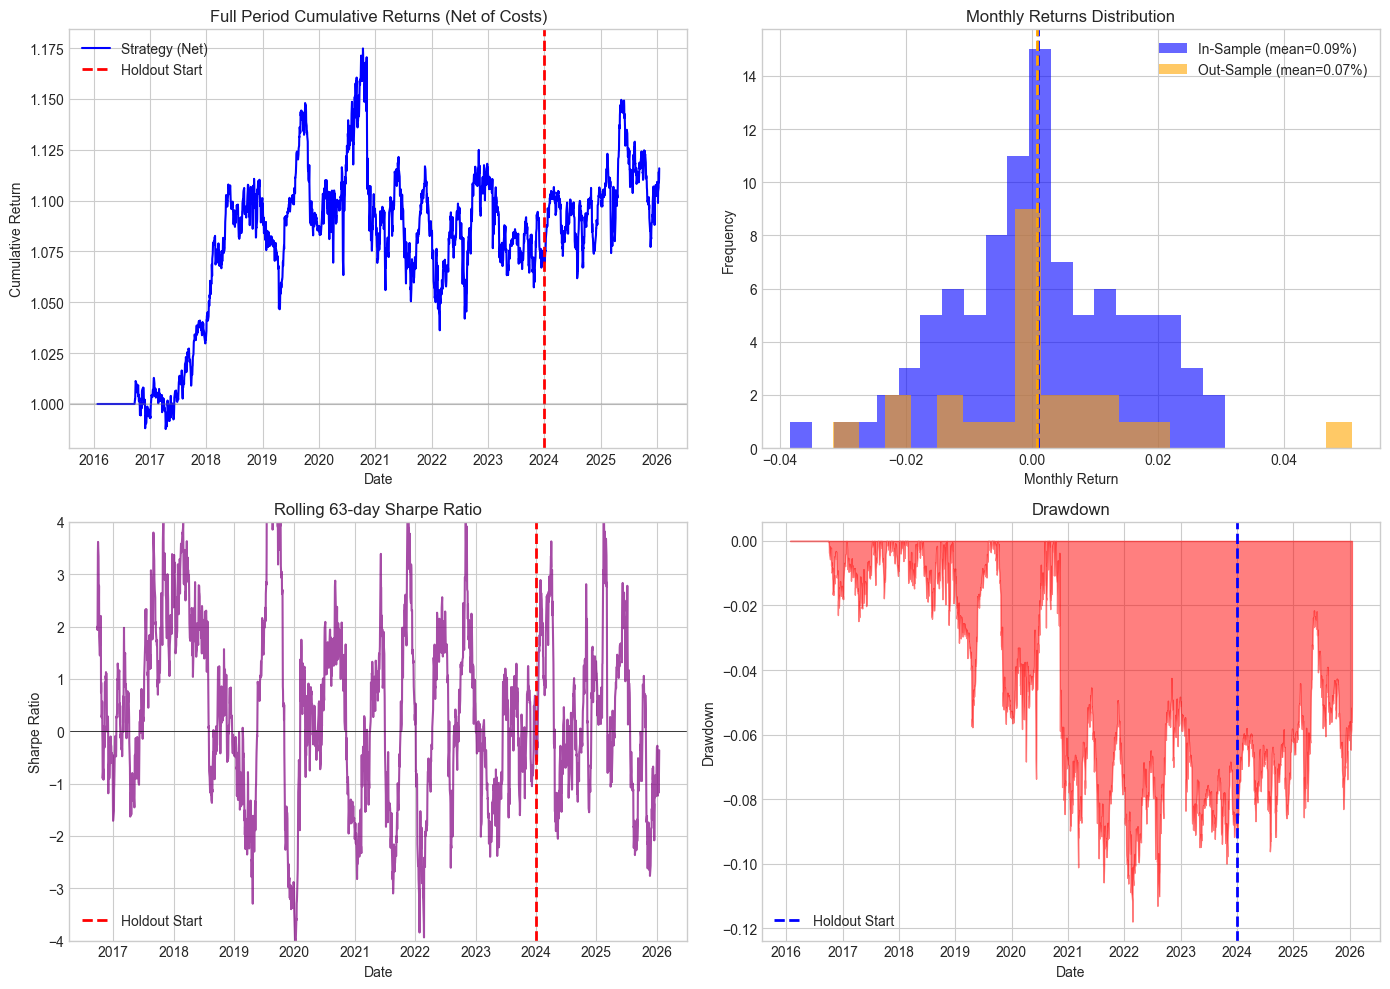

In [7]:
# Visualize In-Sample vs Out-of-Sample Performance
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Full equity curve
ax = axes[0, 0]
full_results = backtest_strategy(returns, lookback=126, skip=42, rev_window=21,
                                  mom_weight=0.6, rev_weight=0.4, rebal_freq=21, tc_bps=10)
ax.plot(full_results['cumulative_net'].index, full_results['cumulative_net'], 
        label='Strategy (Net)', color='blue', linewidth=1.5)
ax.axvline(pd.Timestamp(HOLDOUT_START), color='red', linestyle='--', linewidth=2, label='Holdout Start')
ax.set_title('Full Period Cumulative Returns (Net of Costs)', fontsize=12)
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.legend()
ax.axhline(1, color='gray', linestyle='-', alpha=0.3)

# Plot 2: Monthly returns comparison
ax = axes[0, 1]
is_monthly = is_results['daily_returns_net'].resample('M').sum()
oos_monthly = oos_results['daily_returns_net'].resample('M').sum()
ax.hist(is_monthly, bins=20, alpha=0.6, label=f'In-Sample (mean={is_monthly.mean()*100:.2f}%)', color='blue')
ax.hist(oos_monthly, bins=20, alpha=0.6, label=f'Out-Sample (mean={oos_monthly.mean()*100:.2f}%)', color='orange')
ax.axvline(is_monthly.mean(), color='blue', linestyle='--', linewidth=2)
ax.axvline(oos_monthly.mean(), color='orange', linestyle='--', linewidth=2)
ax.set_title('Monthly Returns Distribution', fontsize=12)
ax.set_xlabel('Monthly Return')
ax.set_ylabel('Frequency')
ax.legend()

# Plot 3: Rolling Sharpe
ax = axes[1, 0]
rolling_sharpe = full_results['daily_returns_net'].rolling(63).mean() / full_results['daily_returns_net'].rolling(63).std() * np.sqrt(252)
ax.plot(rolling_sharpe.index, rolling_sharpe, color='purple', alpha=0.7)
ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax.axvline(pd.Timestamp(HOLDOUT_START), color='red', linestyle='--', linewidth=2, label='Holdout Start')
ax.set_title('Rolling 63-day Sharpe Ratio', fontsize=12)
ax.set_xlabel('Date')
ax.set_ylabel('Sharpe Ratio')
ax.legend()
ax.set_ylim(-4, 4)

# Plot 4: Drawdown
ax = axes[1, 1]
drawdown = full_results['cumulative_net'] / full_results['cumulative_net'].cummax() - 1
ax.fill_between(drawdown.index, 0, drawdown.values, color='red', alpha=0.5)
ax.axvline(pd.Timestamp(HOLDOUT_START), color='blue', linestyle='--', linewidth=2, label='Holdout Start')
ax.set_title('Drawdown', fontsize=12)
ax.set_xlabel('Date')
ax.set_ylabel('Drawdown')
ax.legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'final_oos_evaluation.png', dpi=150)
plt.show()


BENCHMARK COMPARISON:

Equal-Weight Buy-Hold Benchmark (Holdout Period):
  Sharpe:       1.448
  Ann Return:   19.30%
  Max Drawdown: -15.05%

Strategy vs Benchmark (Out-of-Sample):
  Strategy Sharpe:  0.159
  Benchmark Sharpe: 1.448
  Alpha:            -18.42% annual


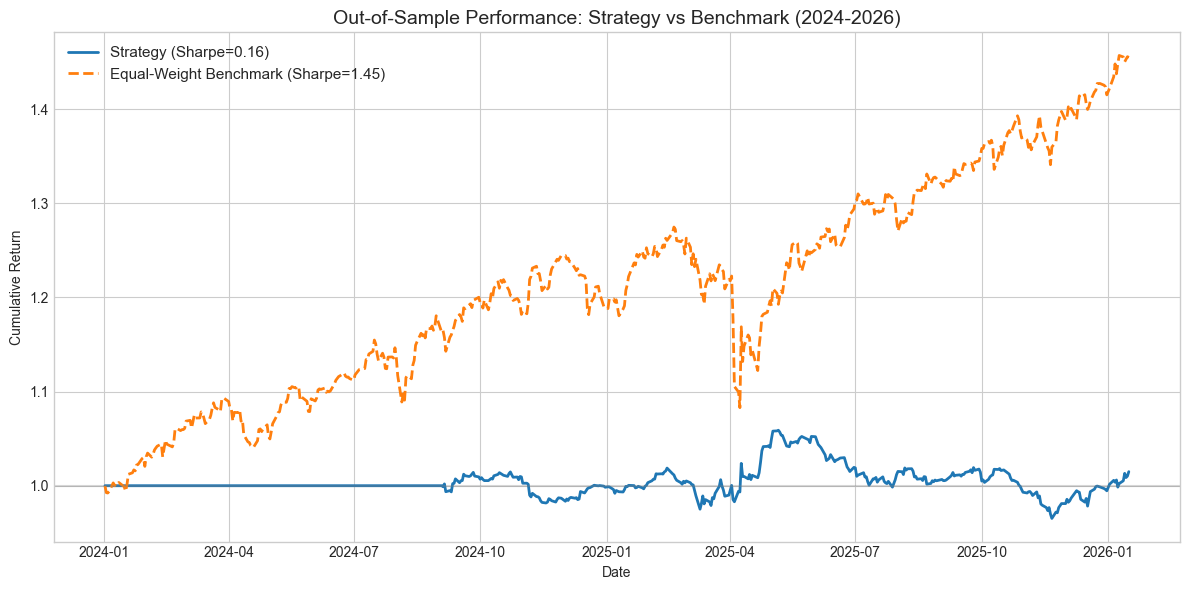

In [8]:
# Create benchmark comparison
print("\nBENCHMARK COMPARISON:")
print("="*60)

# Equal-weight buy-and-hold benchmark
ew_returns = returns_oos.mean(axis=1)
ew_cum = (1 + ew_returns).cumprod()
ew_sharpe = ew_returns.mean() / ew_returns.std() * np.sqrt(252)
ew_ann_ret = ew_returns.mean() * 252
ew_max_dd = (ew_cum / ew_cum.cummax() - 1).min()

print(f"\nEqual-Weight Buy-Hold Benchmark (Holdout Period):")
print(f"  Sharpe:       {ew_sharpe:.3f}")
print(f"  Ann Return:   {ew_ann_ret*100:.2f}%")
print(f"  Max Drawdown: {ew_max_dd*100:.2f}%")

print(f"\nStrategy vs Benchmark (Out-of-Sample):")
print(f"  Strategy Sharpe:  {oos_results['net_sharpe']:.3f}")
print(f"  Benchmark Sharpe: {ew_sharpe:.3f}")
print(f"  Alpha:            {(oos_results['net_return'] - ew_ann_ret)*100:.2f}% annual")

# Plot strategy vs benchmark
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(oos_results['cumulative_net'].index, oos_results['cumulative_net'], 
        label=f'Strategy (Sharpe={oos_results["net_sharpe"]:.2f})', linewidth=2)
ax.plot(ew_cum.index, ew_cum, 
        label=f'Equal-Weight Benchmark (Sharpe={ew_sharpe:.2f})', linewidth=2, linestyle='--')
ax.axhline(1, color='gray', linestyle='-', alpha=0.3)
ax.set_title('Out-of-Sample Performance: Strategy vs Benchmark (2024-2026)', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.legend(fontsize=11)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'final_oos_vs_benchmark.png', dpi=150)
plt.show()

In [9]:
# Final Summary
print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║               FINAL EVALUATION SUMMARY                                       ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")

# Determine success/failure
success_sharpe = oos_results['net_sharpe'] > 0
success_vs_benchmark = oos_results['net_sharpe'] > ew_sharpe
success_drawdown = abs(oos_results['max_dd_net']) < 0.20  # Less than 20% drawdown

print(f"Strategy: 60% Momentum (126d-42d) + 40% Mean Reversion (21d)")
print(f"Rebalancing: Monthly | Transaction Costs: 10 bps")
print()

print("OUT-OF-SAMPLE METRICS (2024-2026):")
print(f"{'─'*50}")
print(f"  Net Sharpe:      {oos_results['net_sharpe']:>10.3f}   {'✅' if success_sharpe else '❌'}")
print(f"  Net Return:      {oos_results['net_return']*100:>10.2f}%")
print(f"  Max Drawdown:    {oos_results['max_dd_net']*100:>10.2f}%  {'✅' if success_drawdown else '⚠️'}")
print(f"  vs Benchmark:    {'OUTPERFORM' if success_vs_benchmark else 'UNDERPERFORM':>10}   {'✅' if success_vs_benchmark else '❌'}")
print()

# Overall assessment
print("OVERALL ASSESSMENT:")
print(f"{'─'*50}")
if success_sharpe and success_vs_benchmark:
    print("🎉 SUCCESS: Strategy shows positive out-of-sample performance!")
    print("   The alpha discovered in-sample has survived into new data.")
elif success_sharpe:
    print("⚠️ PARTIAL SUCCESS: Strategy is profitable but doesn't beat benchmark.")
    print("   The alpha exists but may not be strong enough.")
else:
    print("❌ FAILED: Strategy shows negative out-of-sample performance.")
    print("   This suggests in-sample results may have been overfit.")

print()
print(f"Note: This evaluation used {len(returns_oos)} days of completely unseen data.")
print(f"The strategy parameters were fixed based ONLY on 2016-2023 data.")


╔══════════════════════════════════════════════════════════════════════════════╗
║               FINAL EVALUATION SUMMARY                                       ║
╚══════════════════════════════════════════════════════════════════════════════╝

Strategy: 60% Momentum (126d-42d) + 40% Mean Reversion (21d)
Rebalancing: Monthly | Transaction Costs: 10 bps

OUT-OF-SAMPLE METRICS (2024-2026):
──────────────────────────────────────────────────
  Net Sharpe:           0.159   ✅
  Net Return:            0.88%
  Max Drawdown:         -8.84%  ✅
  vs Benchmark:    UNDERPERFORM   ❌

OVERALL ASSESSMENT:
──────────────────────────────────────────────────
⚠️ PARTIAL SUCCESS: Strategy is profitable but doesn't beat benchmark.
   The alpha exists but may not be strong enough.

Note: This evaluation used 513 days of completely unseen data.
The strategy parameters were fixed based ONLY on 2016-2023 data.


In [11]:
# Save final results
final_results = {
    'strategy': '60% Momentum (126d-42d) + 40% Mean Reversion (21d)',
    'parameters': {
        'momentum_lookback': 126,
        'momentum_skip': 42,
        'reversion_window': 21,
        'momentum_weight': 0.6,
        'reversion_weight': 0.4,
        'rebalance_freq': 21,
        'transaction_cost_bps': 10
    },
    'in_sample': {
        'period': f"{returns_is.index[0].date()} to {returns_is.index[-1].date()}",
        'days': len(returns_is),
        'net_sharpe': float(is_results['net_sharpe']),
        'net_return': float(is_results['net_return']),
        'max_drawdown': float(is_results['max_dd_net']),
        'turnover': float(is_results['ann_turnover'])
    },
    'out_of_sample': {
        'period': f"{returns_oos.index[0].date()} to {returns_oos.index[-1].date()}",
        'days': len(returns_oos),
        'net_sharpe': float(oos_results['net_sharpe']),
        'net_return': float(oos_results['net_return']),
        'max_drawdown': float(oos_results['max_dd_net']),
        'turnover': float(oos_results['ann_turnover'])
    },
    'benchmark': {
        'type': 'Equal-Weight Buy-Hold',
        'sharpe': float(ew_sharpe),
        'ann_return': float(ew_ann_ret),
        'max_drawdown': float(ew_max_dd)
    },
    'success_criteria': {
        'positive_sharpe': bool(success_sharpe),
        'beats_benchmark': bool(success_vs_benchmark),
        'acceptable_drawdown': bool(success_drawdown)
    }
}

with open(OUTPUT_DIR / 'final_evaluation_results.json', 'w') as f:
    json.dump(final_results, f, indent=2)

print("✅ Final results saved to outputs/final_evaluation_results.json")

✅ Final results saved to outputs/final_evaluation_results.json
